# Assessing the feasibility of predicting a crash

The objective is to understand whether it is possible to predict the risk of an accident along a selected traffic route based on historical data.Risk is defined as the probability of an accident involving any damage to a vehicle.

The study should investigate whether modeling results and factor importance analysis can help answer the questions:

- Is it possible to create an adequate driver risk assessment system for auto dispensing?
- What other factors need to be considered?
- Does the vehicle need to be equipped with any sensors or camera?

## Connect to the database. Load sql tables

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics

from sqlalchemy import create_engine
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_score, accuracy_score, recall_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostClassifier

In [2]:

db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 


In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string) 


## Conduct primary research on the tables

#### Table case_ids

In [5]:
query = '''

SELECT *
FROM case_ids
LIMIT 5

'''

case_id_df = pd.read_sql_query(query, con=engine) 
case_id_df.head()

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


The table contains a unique case_id, the second column is different from the one presented in the documentation and most likely denotes the year the database was created.

#### Table vehicles

In [6]:
query = '''

SELECT *
FROM vehicles
LIMIT 5

'''

vehicles_df = pd.read_sql_query(query, con=engine) 
vehicles_df

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


The table contains data on the vehicles involved in the accident.

#### Table parties

In [7]:
query = '''

SELECT *
FROM parties
LIMIT 5

'''

parties_df = pd.read_sql_query(query, con=engine) 
parties_df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


The table contains a description of the participants in the incident, the column names correspond to the description, but the columns contain the full name instead of a letter abbreviation as indicated in the data description.

#### Table collisions

In [8]:
query = '''

SELECT *
FROM collisions
LIMIT 5
'''

collisions_df = pd.read_sql_query(query, con=engine) 
collisions_df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


The table contains information about the incident, the contents of the columns also do not use alphabetic abbreviations.

The common key for linking the tables is the case_id field.

## Conduct a statistical analysis of road traffic accident factors

Let's find out in which months the largest number of accidents occurs. To do this, let's unload the necessary columns from the collisions table, calculate the number of case_id and group them by month.

In [9]:
query = '''

SELECT DISTINCT extract(MONTH FROM cast(collision_date AS date))::int AS collision_month,
                count(case_id) AS case_count
FROM collisions
GROUP BY 1
'''
coll_count_df = pd.read_sql_query(query, con=engine) 
coll_count_df

,collision_month,case_count
0,1,132044
1,2,128858
2,3,139581
3,4,130180
4,5,130316
5,6,102594
6,7,102227
7,8,104089
8,9,105159
9,10,112237


Visualize the resulting data:

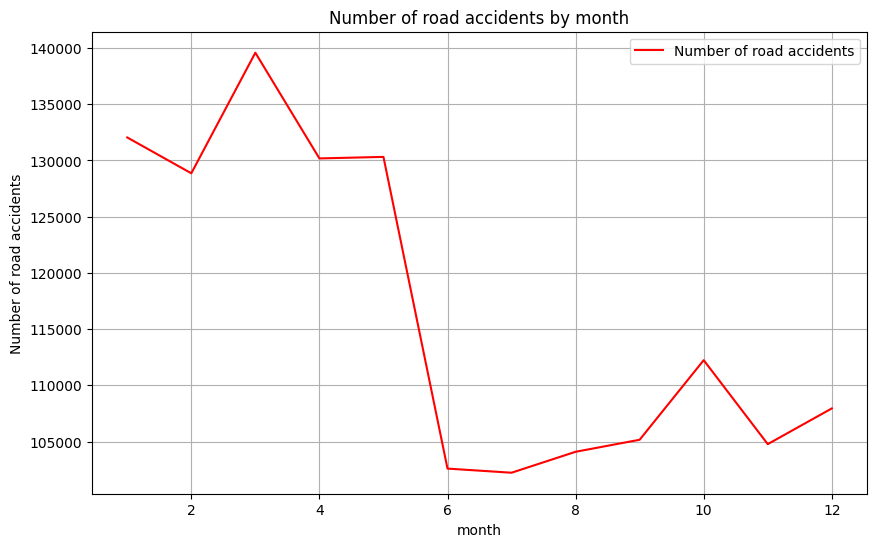

In [10]:
plt.figure(figsize=[10,6])
sns.lineplot(data=coll_count_df, x='collision_month', y='case_count', label='Number of road accidents', color='red')
plt.legend()
plt.title('Number of road accidents by month')
plt.xlabel('month')
plt.ylabel('Number of road accidents')
plt.grid()
plt.show()

The highest number of road accidents is observed in the period from January to May, followed by a sharp decline, with the peak in March. Such a surge can be explained by unfavorable weather conditions and road conditions in winter-spring period, or incomplete data for the period from June to December.

### Problem Statement 
1. Find accidents with more than 4 participants in which the driver was talking on the phone.
    - Merge the collisions and parties tables;
    - Display on a bar chart the number of accidents with and without phone use.

2. Find out the severity of the damage to the vehicle based on the condition of the driver.

3. Identify the five counties in which drunk drivers are the most likely to cause an accident at night (23:00 to 05:00) and the average age of the vehicles in those counties
    - Combine the tables vehicles, collisions, and parties.
    - Output the name of the county, the number of accident perpetrators in descending order, and the average age of the car for each region.

4. Output the number of unique id of accidents involving minivans by month.

5. Find out the percentage change in the number of bicycle accidents each month from March 1 to October 31, 2011, output the month number, the number of accidents, and the percentage.

6. Find out which car with which body type is most likely to be involved in a crash.


#### Task 1
Let's find out the severity of damage to the vehicle based on the condition of the driver.

In [11]:
query = '''
SELECT c.collision_damage,
       p.party_drug_physical
  FROM collisions AS c
       JOIN parties AS p ON c.case_id = p.case_id
 WHERE p.party_drug_physical IN ('not applicable', 'G');
'''

condition_df = pd.read_sql_query(query, con=engine)


condition_df

,collision_damage,party_drug_physical
0,small damage,not applicable
1,small damage,G
2,small damage,not applicable
3,small damage,not applicable
4,small damage,not applicable
...,...,...
402239,small damage,G
402240,small damage,not applicable
402241,small damage,not applicable
402242,small damage,not applicable


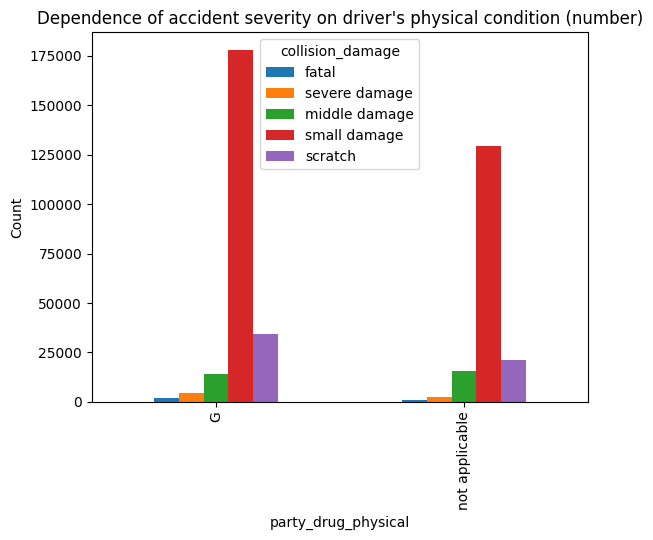

In [13]:

damage_categories = ['fatal', 'severe damage', 'middle damage', 'small damage', 'scratch']

df_grouped = condition_df.groupby(['party_drug_physical', 'collision_damage']).size().unstack(fill_value=0)

df_grouped = df_grouped[damage_categories]


df_grouped.plot(kind='bar', stacked=False)

plt.title("Dependence of accident severity on driver's physical condition (number)")
plt.xlabel('party_drug_physical')
plt.ylabel('Count')
plt.legend(title='collision_damage')

plt.show()


In cases where the physical condition is unknown or not applicable - the statistics of the types of damage are very similar. Most crashes end up with minor damage or scratches.

#### Task 2
Identify the five counties in which drunk drivers are most frequently involved in crashes at night (23:00 to 05:00), as well as the average age of the vehicles in those counties.

In [14]:
query = '''

SELECT county_location,
       count(c.case_id) AS case_count,
       round(avg(v.vehicle_age), 1) AS avg_vehicle_age
FROM parties p
JOIN collisions c ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id
WHERE at_fault = 1
  AND party_sobriety like '%%had been%%'
  AND (extract(HOUR FROM cast(collision_time AS TIME))::int <= 5
       OR extract(HOUR FROM cast(collision_time AS TIME))::int >= 23)
GROUP BY county_location
ORDER BY 2 DESC
LIMIT 5

'''
drunk_df = pd.read_sql_query(query, con=engine) 
drunk_df

,county_location,case_count,avg_vehicle_age
0,los angeles,10909,4.3
1,san diego,3116,4.2
2,orange,3084,4.1
3,san bernardino,1991,4.2
4,riverside,1973,4.2


Los Angeles ranks first, but given a population of 10 million, and for example San Diego County's population of 3 million, the proportions are pretty much the same.

## Create a model to estimate driver risk

### Identifying attributes and uploading data
Before creating the model, let's identify the factors affecting the target attribute `at_fault`.

Table `vehicles`:

- `vehicle_transmission` - autos with an automatic transmission may be more difficult for inexperienced carshare drivers.

Table `parties`:

- `at_fault` - target attribute;
- `cellphone_in_use` - phone use reduces attentiveness;
- `party_sobriety` - driver sobriety;

Table `collisions`:

- `weather_1` - weather;
- `intersection` - most often, according to statistics, it is at intersections that accidents occur;
- `pcf_violation_category` - the main cause of the accident, identifying the cause will prevent accidents in the future;
- `motor_vehicle_involved_with` - additional participants in the accident, identifying the most frequent participants will reduce the number of accidents;
- `road_surface` - road surface condition - ice, wet/slippery/dry road;
- `control_device` - presence of a control device - unknown factor that may have an impact.
- `lighting` - road illumination.

With the help of the query we will unload the necessary data into the table. By the condition of the task, we need only data for 2012, where the participant of the accident is a car with damage greater than a scratch.

In [15]:
query = '''
SELECT *
  FROM parties AS p
       FULL JOIN vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number
       FULL JOIN collisions AS c ON p.case_id = c.case_id
 WHERE p.party_type = 'car'
       AND c.collision_damage != 'scratch'
       AND c.collision_date BETWEEN '2012-01-01' AND '2012-12-31';
'''

df = pd.read_sql_query(query, con=engine)

df.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,2685660,5615920,4,car,0,NaN,impairment unknown,G,0.0,NaN,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-04-20,14:20:00
1,2451790,5479299,5,car,0,42.0,had not been drinking,None,0.0,NaN,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with no street lights,none,2012-01-05,23:30:00
2,2501895,5506033,5,car,0,NaN,impairment unknown,G,0.0,NaN,...,vehicle code violation,following too closely,rear end,other motor vehicle,dry,normal,daylight,none,2012-01-27,07:50:00
3,2566408,5540974,5,car,0,21.0,had not been drinking,None,0.0,1412449.0,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-03-05,14:35:00
4,2738734,5644968,5,car,0,26.0,had not been drinking,None,NaN,NaN,...,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-06-05,18:00:00


In [16]:
df.isna().sum()/len(df)

id                             0.000000
case_id                        0.000000
party_number                   0.000000
party_type                     0.000000
at_fault                       0.000000
insurance_premium              0.102775
party_sobriety                 0.018416
party_drug_physical            0.872239
cellphone_in_use               0.128904
id                             0.714241
case_id                        0.714241
party_number                   0.714241
vehicle_type                   0.714241
vehicle_transmission           0.718605
vehicle_age                    0.722847
case_id                        0.000000
county_city_location           0.000000
county_location                0.000000
distance                       0.000000
direction                      0.217754
intersection                   0.005014
weather_1                      0.003323
location_type                  0.556196
collision_damage               0.000000
party_count                    0.000000


We'll clean the data

In [17]:
df.drop(columns=[
    'case_id', 'id', 'party_number', 'county_city_location', 'collision_date', 'collision_time', 'party_type'
], inplace=True, errors='ignore')

In [18]:
df.drop_duplicates(inplace=True, ignore_index=True)


In [19]:
df.rename(columns={'weather_1':'weather', 'road_condition_1':'road_condition'}, inplace=True)


In [20]:
df.drop(index=df[df['distance'] > df['distance'].quantile(0.99)].index, inplace=True)

df.drop(index=df[df['vehicle_age'] > df['vehicle_age'].quantile(0.99)].index, inplace=True)

df['direction'] = df['direction'].fillna('unknown')

df['location_type'] = df['location_type'].fillna('road')

df['primary_collision_factor'] = df['primary_collision_factor'].fillna('unknown')

df['pcf_violation_category'] = df['pcf_violation_category'].fillna('unknown')

df['party_sobriety'] = df['party_sobriety'].fillna('impairment unknown')

df['party_drug_physical'] = df['party_drug_physical'].fillna('impairment unknown')
df['party_drug_physical'] = df['party_drug_physical'].replace('G', 'impairment unknown')

df.drop(index=df[df['vehicle_type'] == 'other'].index, inplace=True)
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

df['vehicle_transmission'] = df['vehicle_transmission'].fillna('unknown')

df['cellphone_in_use'] = df['cellphone_in_use'].fillna('unknown')
df['cellphone_in_use'] = df['cellphone_in_use'].replace(0, 'no')
df['cellphone_in_use'] = df['cellphone_in_use'].replace(1, 'yes')

df['intersection'] = df['intersection'].replace(0, 'no')
df['intersection'] = df['intersection'].replace(1, 'yes')

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [21]:
df.isna().sum()/len(df)

at_fault                       0.0
insurance_premium              0.0
party_sobriety                 0.0
party_drug_physical            0.0
cellphone_in_use               0.0
vehicle_type                   0.0
vehicle_transmission           0.0
vehicle_age                    0.0
county_location                0.0
distance                       0.0
direction                      0.0
intersection                   0.0
weather                        0.0
location_type                  0.0
collision_damage               0.0
party_count                    0.0
primary_collision_factor       0.0
pcf_violation_category         0.0
type_of_collision              0.0
motor_vehicle_involved_with    0.0
road_surface                   0.0
road_condition                 0.0
lighting                       0.0
control_device                 0.0
dtype: float64

In [22]:
df['lighting'].unique() 

array(['daylight', 'dark with street lights',
       'dark with street lights not functioning',
       'dark with no street lights', 'dusk or dawn'], dtype=object)

To get rid of gaps in the names and too many categories - assign a value of dark to all categories denoting an unlit street.

In [23]:
def fix_value(cell):
    cell = cell.replace(' ', '_')  # function that replaces all spaces with underscores
    return cell 

In [24]:
df['lighting'] = df['lighting'].apply(lambda x: 'dark' if 'dark' in x else x)
df['lighting'] = df['lighting'].apply(fix_value)

In [25]:
df['party_sobriety'].unique() 

array(['had not been drinking', 'impairment unknown',
       'had been drinking, under influence', 'not applicable',
       'had been drinking, impairment unknown',
       'had been drinking, not under influence'], dtype=object)

Let's do the same with the party_sobriety attribute, leaving only the fact whether the participant was intoxicated or not:

In [26]:
df['party_sobriety'] = df['party_sobriety'].apply(lambda x: 'sober' if 'had not' in x else x)
df['party_sobriety'] = df['party_sobriety'].apply(lambda x: 'drunk' if 'had been' in x else x)
df['party_sobriety'] = df['party_sobriety'].apply(lambda x: 'drunk' if 'impairment' in x else x)

df['party_sobriety'] = df['party_sobriety'].apply(fix_value)

Next, let's look at the categories of violations.

In [27]:
df['pcf_violation_category'].unique() 

array(['speeding', 'traffic signals and signs', 'automobile right of way',
       'other improper driving', 'wrong side of road',
       'other hazardous violation', 'improper turning',
       'pedestrian violation', 'unsafe lane change', 'dui',
       'following too closely', 'unknown', 'improper passing',
       'other equipment', 'unsafe starting or backing',
       'other than driver (or pedestrian)', 'pedestrian right of way',
       'hazardous parking', 'impeding traffic', 'lights', 'brakes',
       'fell asleep'], dtype=object)

Here it is possible to combine pedestrian violations into one group, since the objective is to consider the causes of car accidents only. It is also possible to combine technical faults into one category.

In [28]:
df['pcf_violation_category'] = df['pcf_violation_category'].apply(lambda x: 'equipment_fault' if x == 'brakes' 
                                                                  or x == 'other equipment'
                                                                  or x == 'lights' else x)
df['pcf_violation_category'] = df['pcf_violation_category'].apply(lambda x: 'pedestrian_involved' if x == 'automobile right of way' 
                                                                  or x == 'pedestrian violation' 
                                                                  or x == 'dui' 
                                                                  or x == 'other than driver (or pedestrian)'  
                                                                  or x == 'improper passing' else x)

df['pcf_violation_category'] = df['pcf_violation_category'].apply(fix_value)

In [29]:
df['motor_vehicle_involved_with'].unique() 

array(['other motor vehicle', 'other object', 'fixed object',
       'motor vehicle on other roadway', 'non-collision', 'bicycle',
       'parked motor vehicle', 'train', 'animal'], dtype=object)

Let's combine the values in the column with additional participants in the accident

In [30]:
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].apply(lambda x: 'other_vehicle' if x == 'other motor vehicle' 
                                                                  or x == 'motor vehicle on other roadway' else x)

df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].apply(lambda x: 'fixed object' if x == 'parked motor vehicle' else x)
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].apply(fix_value)

### Sampling and feature coding

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('at_fault', axis=1), 
                                                    df['at_fault'], 
                                                    train_size=0.8, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                   stratify=df['at_fault']) 

In [32]:
categorial = ['party_sobriety', 'party_drug_physical',
    'cellphone_in_use', 'vehicle_type', 'vehicle_transmission',
    'county_location', 'direction',
    'intersection', 'weather', 'location_type',
    'collision_damage', 'primary_collision_factor', 'pcf_violation_category',
    'type_of_collision', 'motor_vehicle_involved_with', 'road_surface',
    'road_condition', 'lighting', 'control_device']

numeric =['at_fault', 'insurance_premium', 'distance', 'party_count', 'vehicle_age']

In [34]:
tmp_train = X_train[categorial]
tmp_test= X_test[categorial]


encoder_ohe = OneHotEncoder(drop='first')
encoder_ohe.fit(X_train[categorial])

tmp_train = pd.DataFrame(encoder_ohe.transform(X_train[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=X_train.index)
tmp_test = pd.DataFrame(encoder_ohe.transform(X_test[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=X_test.index)

X_train.drop(categorial, axis=1, inplace=True)
X_train = X_train.join(tmp_train)

X_test.drop(categorial, axis=1, inplace=True)
X_test = X_test.join(tmp_test)

Let's look at the balance of classes:

0    0.500292
1    0.499708
Name: at_fault, dtype: float64


<Axes: >

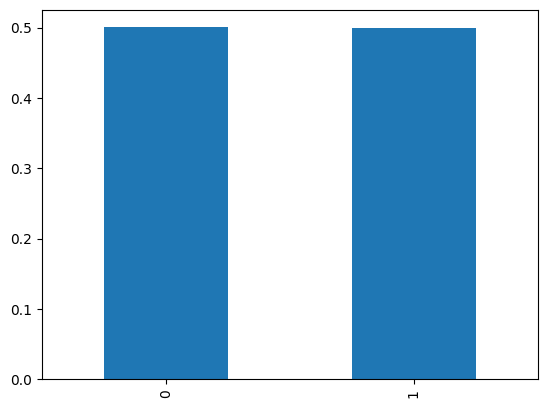

In [35]:
class_frequency = y_train.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

In [36]:
class_frequency[0]/class_frequency[1]

1.0011681105811352

The classes can be considered balanced, the distribution is close to 50%.

When comparing models, we will use precision as the defining metric, because it shows the share of true positive answers.

To calculate metrics and plot the graph, let's define the function metrics_func:

In [37]:
def metrics_func(model):
    model.fit(X_train, y_train)
    predicted_test = model.predict(X_test)
    probabilities_test = model.predict_proba(X_test)
    probabilities_one_test = probabilities_test[:, 1]
    precision = precision_score(y_test, predicted_test)
    recall = recall_score(y_test, predicted_test)
    print('Precision:', precision)
    print('Recall:', recall)
    print('Acuracy score:', accuracy_score(y_test, predicted_test)) 
    print('F1-score:', f1_score(y_test, predicted_test))
    print('AUC-ROC:', roc_auc_score(y_test, probabilities_one_test), '\n')
    print('Confusion matrix:')
    print(confusion_matrix(y_test, predicted_test))

#  AUC-ROC
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

    plt.figure()

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC')
    
    plt.show()
    return precision, predicted_test, probabilities_one_test, model

### Decision Tree Model

In [38]:
params =  {'max_depth': range (1,15, 2),
           'min_samples_leaf': range (1,12),
           'min_samples_split': range (2,14,2)}
           
model = DecisionTreeClassifier()

grid = RandomizedSearchCV(model,
    param_distributions=params, 
    scoring='precision', 
    n_jobs=-1, 
    random_state=12345
)

grid.fit(X_train, y_train)

print(grid.best_params_)


{'min_samples_split': 4, 'min_samples_leaf': 10, 'max_depth': 1}


Precision: 0.9087947882736156
Recall: 0.32593457943925236
Acuracy score: 0.6468528066932581
F1-score: 0.47979363714531387
AUC-ROC: 0.646634410077394 

Confusion matrix:
[[4975  168]
 [3462 1674]]


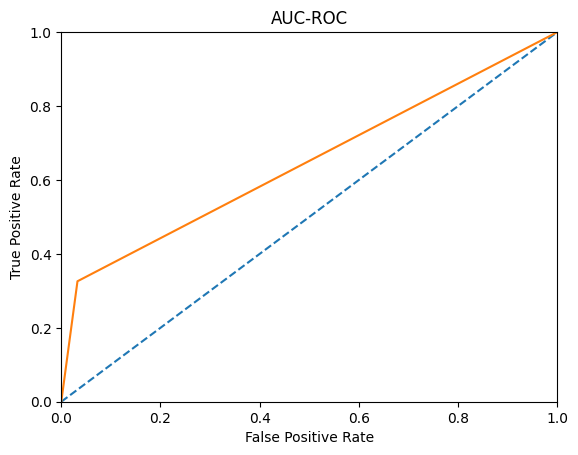

In [39]:
precision_dt, predictions_dt, probabilities_dt, model_dt  = metrics_func(DecisionTreeClassifier(max_depth=1, 
                                                                                             min_samples_split=4, 
                                                                                             min_samples_leaf=10, 
                                                                                             random_state=12345,
                                                                                             class_weight='balanced'))

### Random Forest Model

In [40]:
params =  {'n_estimators': range(10, 155, 15),
           'max_depth': range (1,15),
           'min_samples_leaf': range (1,8),
           'min_samples_split': range (2,10,2)}
           
model = RandomForestClassifier()

grid = RandomizedSearchCV(model,
    param_distributions=params, 
    scoring='precision', 
    n_jobs=-1, 
    random_state=12345
)

grid.fit(X_train, y_train)

print(grid.best_params_)

{'n_estimators': 115, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_depth': 8}


Precision: 0.8922969675845243
Recall: 0.4984423676012461
Acuracy score: 0.7193306741900963
F1-score: 0.6396002498438476
AUC-ROC: 0.7995006937112598 

Confusion matrix:
[[4834  309]
 [2576 2560]]


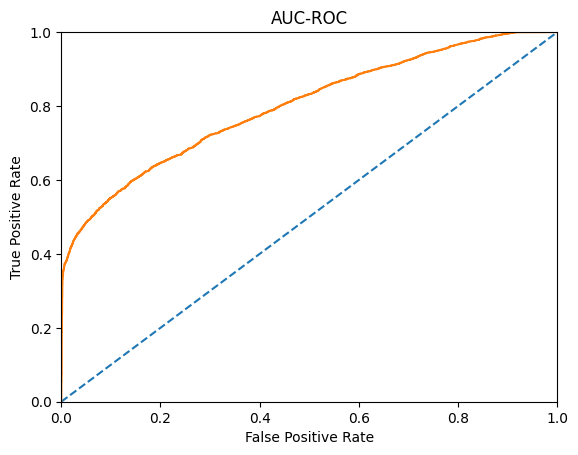

In [41]:
precision_rf, predictions_rf, probabilities_rf, model_rf = metrics_func(RandomForestClassifier(n_estimators=115, 
                                                                                 max_depth=8, 
                                                                                 min_samples_split=4, 
                                                                                 min_samples_leaf=6, 
                                                                                 random_state=12345,
                                                                                 class_weight='balanced'))

### Catboost

In [42]:
params =  {'iterations': range(100, 2600, 500),
           'depth': range (1,15)}
           
model = CatBoostClassifier(verbose=False)

grid = RandomizedSearchCV(model,
    param_distributions=params, 
    scoring='precision', 
    n_jobs=-1, 
    random_state=12345
)

grid.fit(X_train, y_train)

print(grid.best_params_)

/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'iterations': 2100, 'depth': 1}


Precision: 0.8475870494807575
Recall: 0.540303738317757
Acuracy score: 0.7217628173946882
F1-score: 0.6599286563614745
AUC-ROC: 0.7906525057801701 

Confusion matrix:
[[4644  499]
 [2361 2775]]


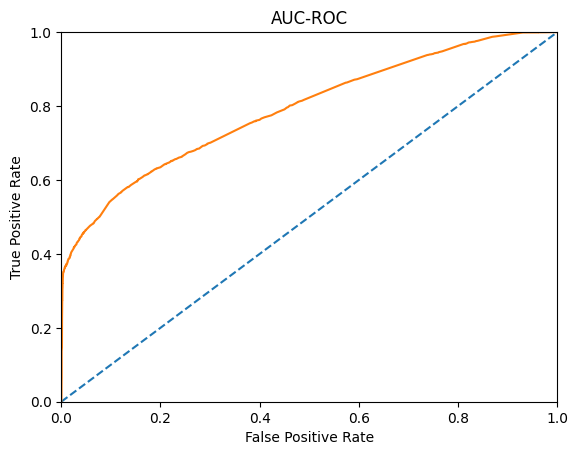

In [43]:
precision_cb, predictions_cb, probabilities_cb, model_cb = metrics_func(CatBoostClassifier(depth=1,
                                                                                        iterations=2100,
                                                                                        random_seed=60,
                                                                                        learning_rate=0.003, 
                                                                                        verbose=False))

## Analyze the importance of road traffic accident factors

Let's analyze the best model

In [44]:
confusion_matrix(y_test, predictions_cb)

array([[4644,  499],
       [2361, 2775]])

Here, as in the matrices for the other models, we see a high number of false positives and a low number of false negatives - it is better to erroneously predict an emergency than to erroneously fail to predict.

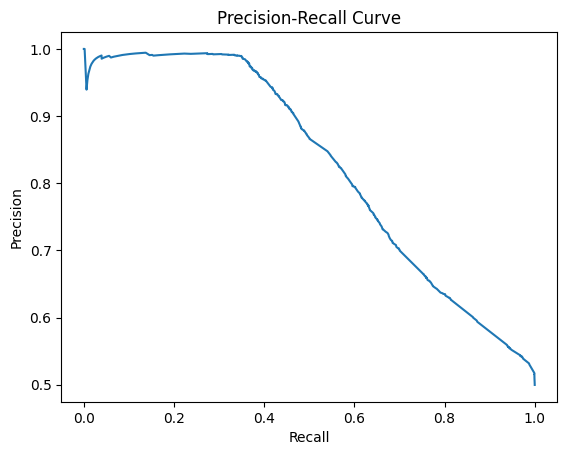

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, probabilities_cb)

fig, ax = plt.subplots()
ax.plot(recall, precision)

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

Let's analyze the importance of the main factors affecting the probability of a traffic accident:

In [46]:
smf = SelectFromModel(model_cb, threshold=-np.inf, max_features = 25)
smf.fit(X_train, y_train)
features_index = smf.get_support()
features_1 = X_train.columns[features_index]
features_1

Index(['insurance_premium', 'vehicle_age', 'distance', 'party_count',
       'party_sobriety_not_applicable', 'party_sobriety_sober',
       'party_drug_physical_impairment unknown',
       'party_drug_physical_not applicable',
       'party_drug_physical_sleepy/fatigued',
       'party_drug_physical_under drug influence', 'cellphone_in_use_unknown',
       'cellphone_in_use_yes', 'vehicle_type_sedan',
       'vehicle_transmission_manual', 'vehicle_transmission_unknown',
       'county_location_alpine', 'county_location_amador',
       'county_location_butte', 'primary_collision_factor_other than driver',
       'primary_collision_factor_vehicle code violation',
       'pcf_violation_category_improper_turning',
       'pcf_violation_category_pedestrian_right_of_way',
       'type_of_collision_overturned',
       'motor_vehicle_involved_with_fixed_object',
       'motor_vehicle_involved_with_other_vehicle'],
      dtype='object')

It is possible to identify the most important factors that influence the likelihood of a traffic accident:

- The fact of alcohol intoxication
- Collision with an object
- Street lighting
- Hitting a pedestrian when the pedestrian had the upper hand
- Wet road



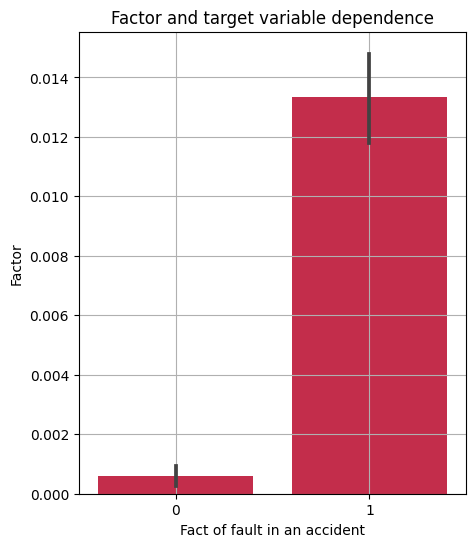

In [54]:
plt.figure(figsize=[5,6])
sns.barplot(x=y_train, y=X_train['party_drug_physical_sleepy/fatigued'], color='crimson')
plt.title('Factor and target variable dependence')
plt.xlabel('Fact of fault in an accident')
plt.ylabel('Factor')
plt.grid()
plt.show()

Here we have taken the sleepy/fatigued driver status indicator. In order to prevent such incidents, cars should preferably be equipped with an emergency braking system, such as Volvo City Safety.

It is also recommended to equip cars with a built-in navigator to warn of speed limits and automatic transmission to increase safety.

## Conclusions

A system of driver risk assessment is likely to be developed, but it is worth considering not only external factors, such as road surface condition or street lighting, but also some data concerning the driver himself, such as experience, previous involvement in accidents as a culprit etc. It is also worth taking into account the density of traffic in the future. To increase safety, it is recommended to equip vehicles with emergency braking systems.